In [1]:
import fenics as fe
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from mshr import *
from gaussian_process import *
from itertools import product
import scipy.stats


# fe.PETScOptions.set("snes_linesearch_monitor", "")
fe.PETScOptions.set("snes_linesearch_type", "bt")

# Define parameters

In [2]:
# Define the necessary parameters
N_SIM = 20    # number of sims
N_F = 1      # number of frequencies
mu = 0.0   
sigma = 5.0
N_POINTS_P_AXIS = 100
TIME_STEP_LENGTH = 0.2
TOTAL_TIME = 2
N_TIME_STEPS = np.floor(TOTAL_TIME/TIME_STEP_LENGTH).astype(int)
KINEMATIC_VISCOSITY = fe.Constant(0.01)
time_vector = np.arange(0.0, TOTAL_TIME, TIME_STEP_LENGTH)

# Generate Fourier coefficients

In [3]:
# Generate the gaussian BCs (using a truncated distribution)
np.random.seed(50)
lower = -10
upper = 10
mu = 0.0
sigma = 5
N_samples = N_SIM*N_F
coeff = np.array(scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N_samples))
#alphaM = np.random.normal(mu, sigma, (N_SIM, N_F)) # we have one row for each realization, and N_F Fourier coefficients along each row
alphaM = coeff.reshape((N_SIM, N_F))
np.save('alpha1.npy',alphaM)

# Print all u_i(t_j) to check if the Reynolds number is in the right order of magnitude
# for i in range(0,N_SIM):
#     for t in time_vector:
#         print(eval_u_t(t, alphaM[i,:], TOTAL_TIME))


# Store $u_i(t_j)$ for comparison

In [4]:
# We create a matrix that stores, in each row, the evaluations of u_i(t_j) for the i-th simulation
# u_t_matrix_Fourier = np.zeros((N_SIM, N_TIME_STEPS))
# for i in range(N_SIM):
#     u_t_matrix_Fourier[i, :] = eval_u_t(time_vector, alphaM[i, :], TOTAL_TIME)
# np.save('u_t_matrix_Fourier', u_t_matrix_Fourier)

In [5]:
# Create XDMF files (one for all the simulations) -> current focus only on velocity
xdmffile_u = fe.XDMFFile('lid_cavity_u_nl.xdmf')
xdmffile_p = fe.XDMFFile('lid_cavity_p_nl.xdmf')
xdmffile_u.parameters["flush_output"] = True
xdmffile_u.parameters["functions_share_mesh"] = True
xdmffile_p.parameters["flush_output"] = True
xdmffile_p.parameters["functions_share_mesh"] = True

In [6]:
# Define an expression for the BC u_t
class u_t_Expression(fe.UserExpression):
    def __init__(self, t, alphav, **kwargs):
        super().__init__(**kwargs)
        self.t = t
        self.alphav = alphav
    def eval(self, value, x):
        value[0] = eval_u_t(self.t, self.alphav, TOTAL_TIME)
        value[1] = 0.0
    def value_shape(self):
        return (2,) 

In [7]:
class BottomVertex(fe.SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0]) < fe.DOLFIN_EPS and abs(x[1]) < fe.DOLFIN_EPS)

In [8]:
def solve_problem(alphav, num_sim):

    
    # Plot the u_t used for the i-th simulation over 2 periods
    t_v = np.linspace(0, 2*TOTAL_TIME, 1000) 
    u_plot = eval_u_t(t_v, alphav, TOTAL_TIME)
    plt.figure(figsize=(10, 5))
    plt.plot(t_v, u_plot)
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.title('u(t) current simulation')
    plt.grid(True)
    plt.show()
    
    # mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS, "crossed")
    domain = Rectangle(fe.Point(0., 0.), fe.Point(1., 1.))
    mesh = generate_mesh(domain, N_POINTS_P_AXIS)
   
    # Taylor-Hood Elements. 
    element_v = fe.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    element_p = fe.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    W = fe.FunctionSpace(mesh, fe.MixedElement(element_v, element_p))
    V = fe.FunctionSpace(mesh, element_v)
    Q = fe.FunctionSpace(mesh, element_p)

    # Define trial functions
    vq = fe.TestFunction(W)
    delta_up = fe.TrialFunction(W)
    (v, q) = fe.split(vq)

    up = fe.Function(W)
    (u, p) = fe.split(up)

    up_prev = fe.Function(W)
    (u_prev, _) = fe.split(up_prev)

    # Define boundary conditions
    g = u_t_Expression(0.0, alphav) 
    noslip = fe.DirichletBC(W.sub(0), (0, 0), "x[0] < DOLFIN_EPS || x[0] > 1.0 - DOLFIN_EPS || x[1] < DOLFIN_EPS")
    lid = fe.DirichletBC(W.sub(0), g, "x[1] > 1.0 - DOLFIN_EPS")
    pref = fe.DirichletBC(W.sub(1), 0, "x[0] < DOLFIN_EPS && x[1] < DOLFIN_EPS", "pointwise")

    bc = [noslip, lid, pref]

    # Stabilization if needed
    # h = fe.CellDiameter(mesh)
    # alpha_u = fe.Constant(1.)
    # delta_u = alpha_u*(h**2)
    # alpha_p = fe.Constant(1.)
    # delta_p = alpha_p*(h**2)
    # rho = fe.Constant(0.)
    # rho =   0 -> SUPG (Streamline updwind Petrov Galerkin)
    # rho =   1 -> GALS (Galerkin least squares)
    # rho = - 1 -> Douglas-Wang

    # Tentative velocity step
    F = fe.inner(u, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        - fe.inner(u_prev, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        + fe.inner(fe.grad(u) * u, v) * fe.dx \
        + KINEMATIC_VISCOSITY * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx \
        - fe.div(v) * p * fe.dx \
        - q * fe.div(u) * fe.dx 
        # + fe.inner(- KINEMATIC_VISCOSITY*fe.div(fe.grad(u)) + fe.grad(p),
        #            -  rho*fe.delta_u*KINEMATIC_VISCOSITY*fe.div(fe.grad(v)) + delta_p*fe.grad(q))*fe.dx  # Stabilization term 

    J = fe.derivative(F, up, delta_up)

    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "mumps",
                                            "maximum_iterations": 20,
                                            "report": False,
                                            "error_on_nonconvergence": True}}

    (u, p) = up.split()
    u.rename("u", "")
    p.rename("p","")
    xdmffile_u.write(u, num_sim*TOTAL_TIME)
    xdmffile_p.write(p, num_sim*TOTAL_TIME)
    
    for i in tqdm(range(1, N_TIME_STEPS)):

        # Go back to "physical" time in order to correctly update the BC
        t = i*TIME_STEP_LENGTH
        g.t = t

        # KINEMATIC_VISCOSITY.assign(1.)
        problem = fe.NonlinearVariationalProblem(F, up, bc, J)
        solver  = fe.NonlinearVariationalSolver(problem)
        solver.parameters.update(snes_solver_parameters)
        solver.solve()

        # Store the solution in up_prev
        fe.assign(up_prev, up)

        # Save
        (u, p) = up.split()
        u.rename("u", "")
        p.rename("p","")
        xdmffile_u.write(u, t+num_sim*TOTAL_TIME)
        xdmffile_p.write(p, t+num_sim*TOTAL_TIME)
        

In [9]:
def main():
    for i in range(N_SIM):
        alphav = alphaM[i, :]
        solve_problem(alphav, i) 

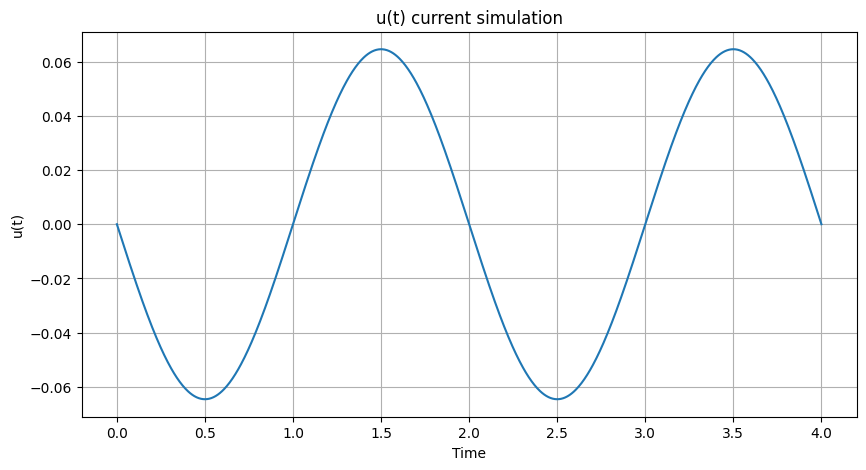

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:05<00:45,  5.71s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:14<00:52,  7.57s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:22<00:46,  7.80s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:29<00:36,  7.39s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:35<00:27,  6.96s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:41<00:20,  6.76s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [00:48<00:13,  6.69s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [00:55<00:06,  6.90s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:04<00:00,  7.18s/it]


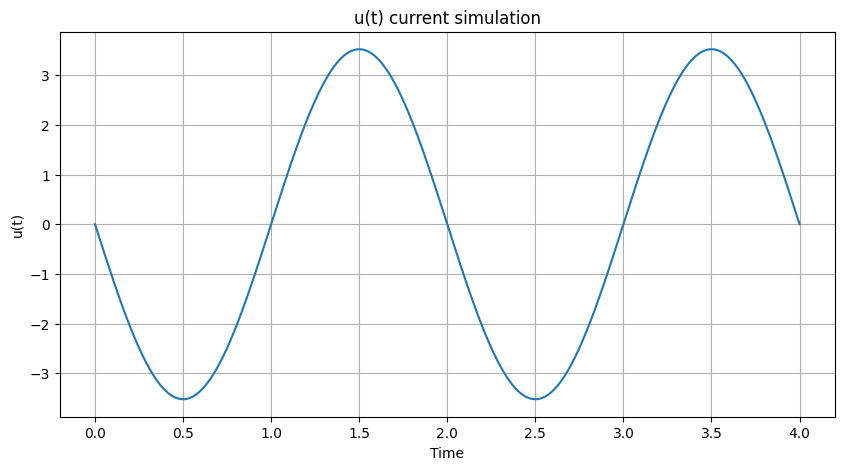

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:13<01:48, 13.52s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:25<01:30, 12.88s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:37<01:12, 12.09s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:45<00:54, 10.80s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:58<00:45, 11.39s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:11<00:36, 12.07s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:23<00:23, 11.90s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:33<00:11, 11.43s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:43<00:00, 11.52s/it]


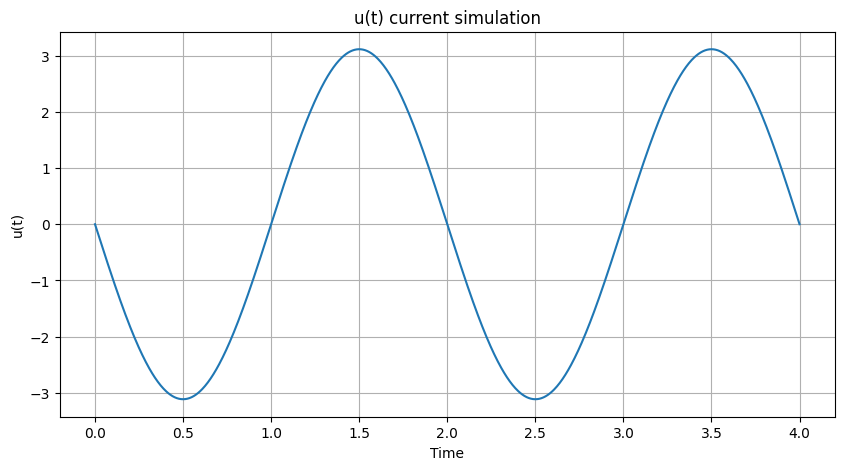

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:11<01:30, 11.34s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:25<01:32, 13.19s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:38<01:18, 13.12s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:47<00:56, 11.32s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:59<00:46, 11.57s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:10<00:34, 11.51s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:21<00:22, 11.31s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:32<00:11, 11.05s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:40<00:00, 11.17s/it]


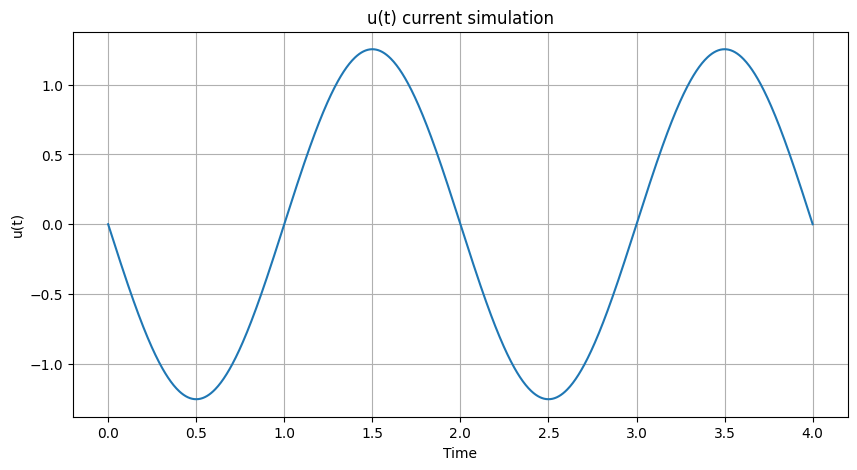

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:05,  8.23s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:17<01:01,  8.81s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:29<01:00, 10.10s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:39<00:50, 10.08s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:50<00:41, 10.47s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:59<00:30, 10.15s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:11<00:21, 10.59s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:20<00:09,  9.99s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:28<00:00,  9.83s/it]


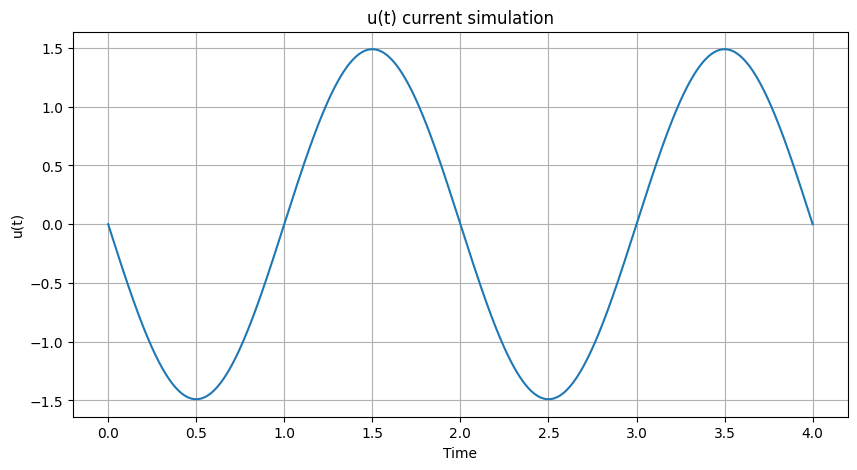

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:09<01:16,  9.62s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:18<01:04,  9.21s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:27<00:55,  9.23s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:37<00:47,  9.40s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:46<00:36,  9.20s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:54<00:27,  9.01s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:04<00:18,  9.06s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:12<00:08,  8.96s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:20<00:00,  8.99s/it]


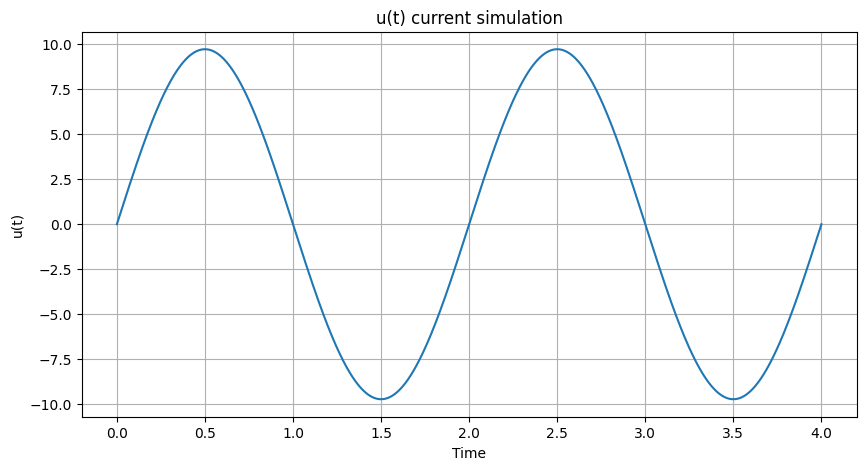

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:12<01:43, 12.88s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:25<01:27, 12.47s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:37<01:14, 12.38s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:47<00:57, 11.43s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:57<00:43, 10.98s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:10<00:35, 11.78s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:23<00:24, 12.13s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:40<00:13, 13.47s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:50<00:00, 12.25s/it]


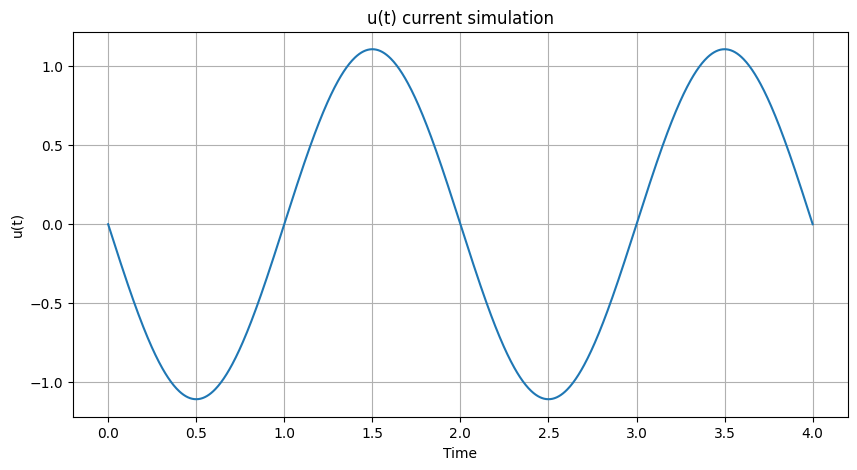

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:04,  8.06s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:16<00:56,  8.11s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:24<00:49,  8.31s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:34<00:44,  8.83s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:45<00:38,  9.70s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:56<00:30, 10.07s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:05<00:19,  9.69s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:14<00:09,  9.44s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:23<00:00,  9.23s/it]


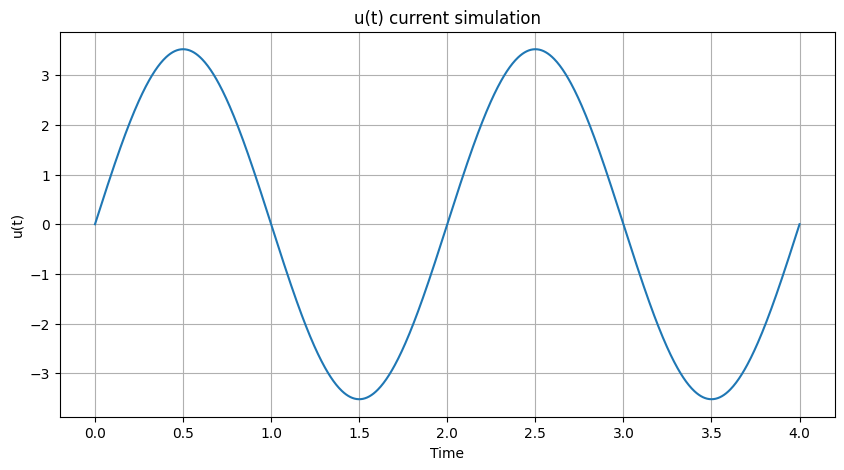

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:12<01:37, 12.22s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:23<01:23, 11.94s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:35<01:09, 11.61s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:44<00:53, 10.70s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:55<00:43, 10.97s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:06<00:32, 10.94s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:18<00:22, 11.19s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:30<00:11, 11.36s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:42<00:00, 11.34s/it]


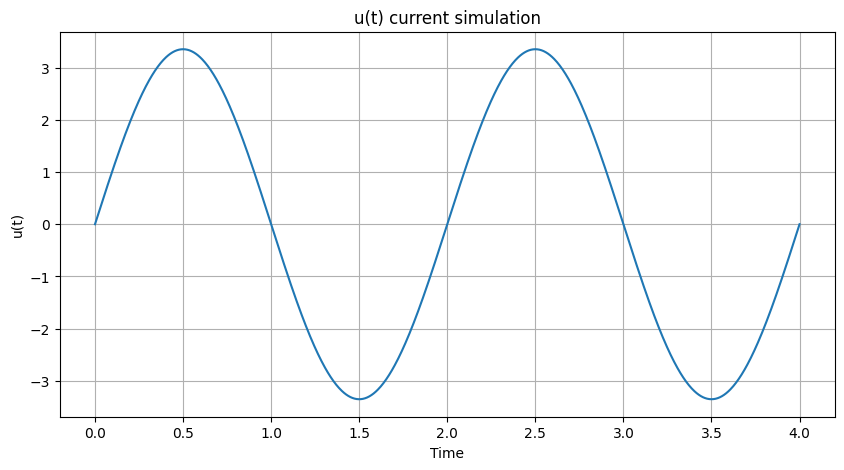

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:12<01:37, 12.19s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:23<01:21, 11.69s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:34<01:07, 11.31s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:43<00:51, 10.34s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:57<00:47, 11.84s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:08<00:34, 11.44s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:19<00:22, 11.29s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:29<00:10, 10.99s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:38<00:00, 10.99s/it]


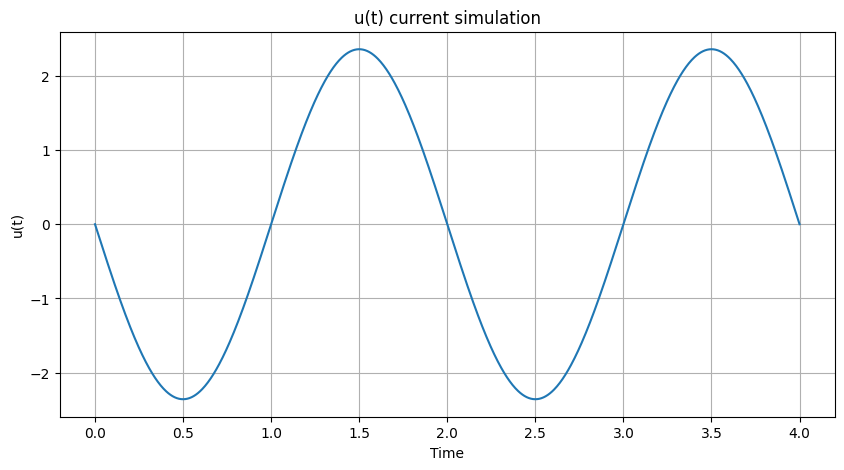

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:09<01:12,  9.03s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:20<01:12, 10.31s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:29<00:58,  9.81s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:37<00:46,  9.25s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:46<00:36,  9.02s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:56<00:28,  9.45s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:05<00:18,  9.17s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:16<00:09,  9.67s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:24<00:00,  9.37s/it]


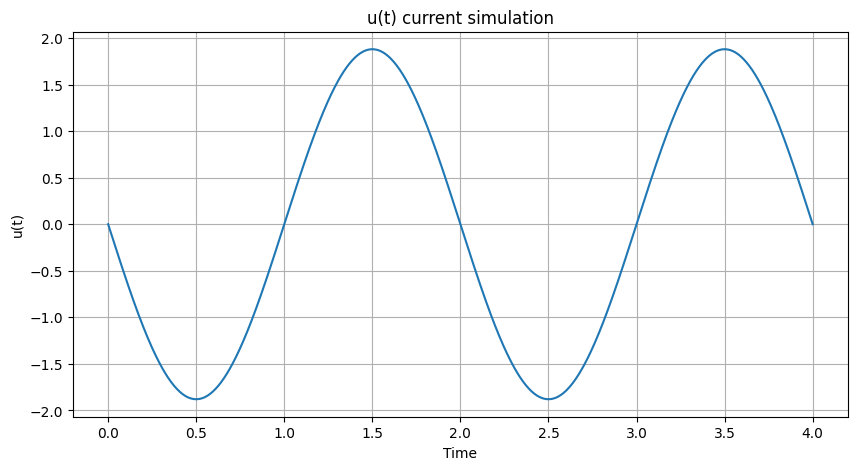

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:07,  8.47s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:16<00:58,  8.34s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:25<00:51,  8.53s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:33<00:42,  8.51s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:42<00:33,  8.35s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:50<00:25,  8.36s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [00:58<00:16,  8.21s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:08<00:08,  8.79s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:17<00:00,  8.56s/it]


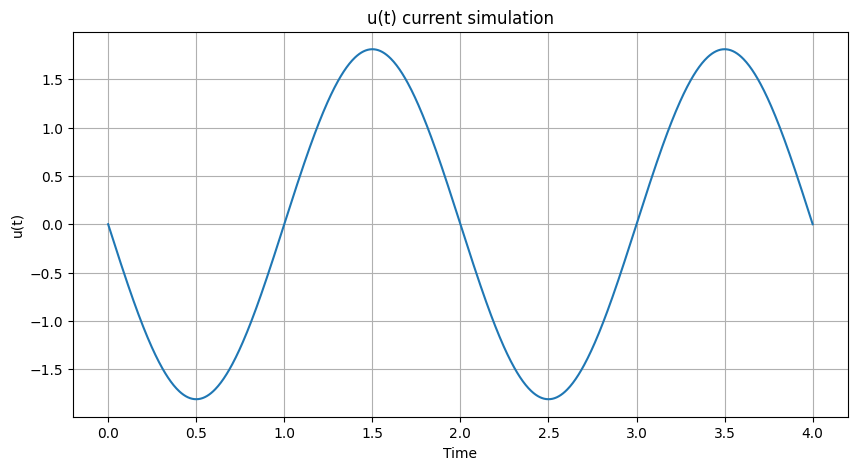

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:09,  8.69s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:17<00:59,  8.53s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:25<00:51,  8.66s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:34<00:43,  8.66s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:43<00:34,  8.75s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:51<00:25,  8.63s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:00<00:17,  8.67s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:09<00:08,  8.72s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:17<00:00,  8.67s/it]


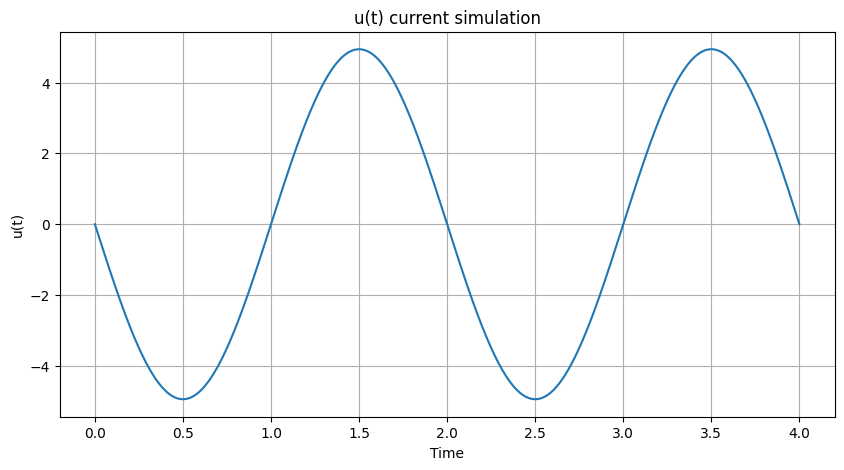

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:10<01:26, 10.86s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:22<01:18, 11.27s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:33<01:07, 11.25s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:42<00:52, 10.47s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:53<00:41, 10.41s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:05<00:32, 10.92s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:16<00:22, 11.04s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:26<00:10, 10.85s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:35<00:00, 10.64s/it]


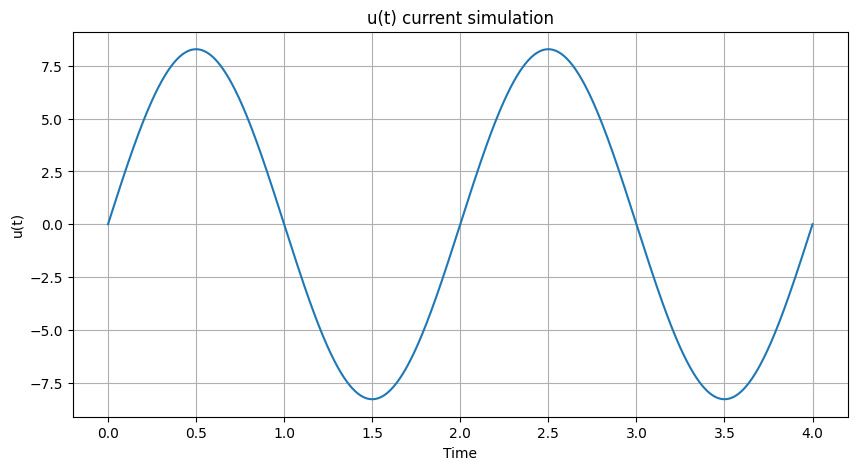

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:15<02:02, 15.29s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:29<01:43, 14.75s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:46<01:34, 15.76s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:54<01:04, 12.82s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [01:05<00:47, 11.93s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:18<00:37, 12.35s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:31<00:25, 12.57s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:43<00:12, 12.50s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:51<00:00, 12.42s/it]


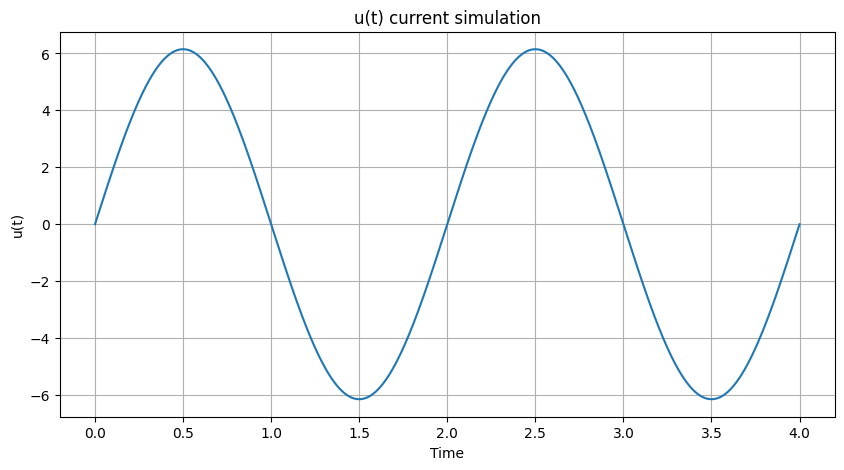

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:10<01:22, 10.34s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:20<01:10, 10.12s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:30<01:01, 10.23s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:38<00:46,  9.40s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:49<00:39,  9.80s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:00<00:30, 10.14s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:11<00:20, 10.39s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:24<00:11, 11.31s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:32<00:00, 10.26s/it]


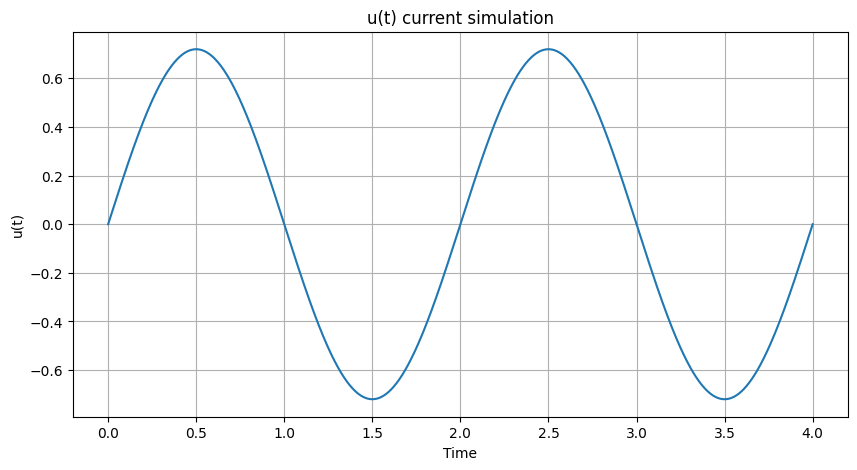

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:09<01:12,  9.01s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:17<01:02,  8.91s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:25<00:51,  8.52s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:33<00:41,  8.22s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:41<00:32,  8.23s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:50<00:24,  8.24s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:00<00:17,  8.84s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:13<00:10, 10.25s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:22<00:00,  9.14s/it]


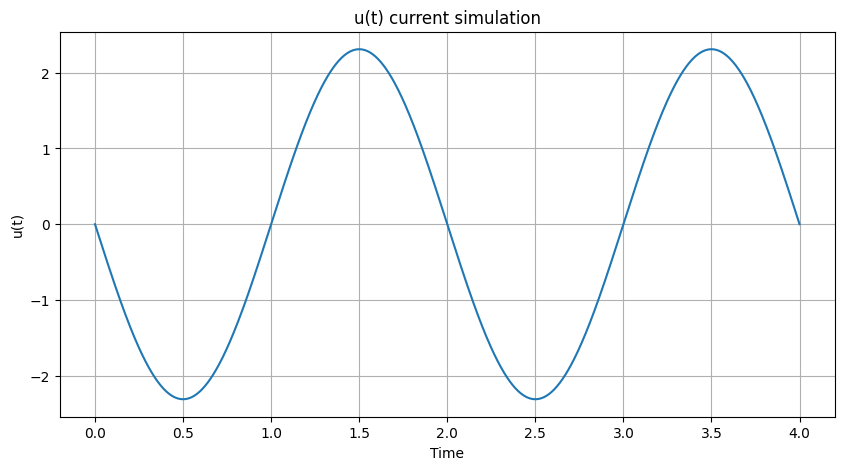

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:11<01:29, 11.13s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:23<01:21, 11.62s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:33<01:05, 10.93s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:43<00:54, 10.87s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:53<00:42, 10.53s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:04<00:31, 10.51s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:15<00:21, 10.77s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:28<00:11, 11.45s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:38<00:00, 10.94s/it]


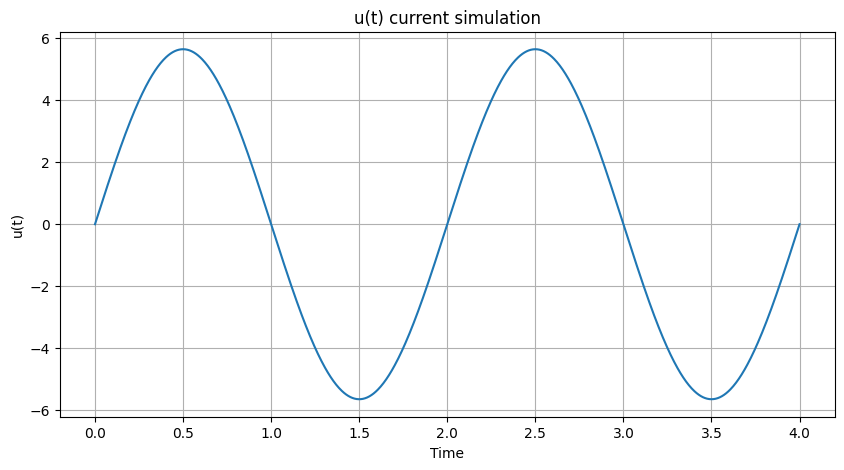

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:13<01:45, 13.18s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:24<01:23, 11.89s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:35<01:10, 11.71s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:44<00:53, 10.64s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:57<00:45, 11.30s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:10<00:35, 11.96s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:23<00:24, 12.29s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:35<00:12, 12.21s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:45<00:00, 11.68s/it]


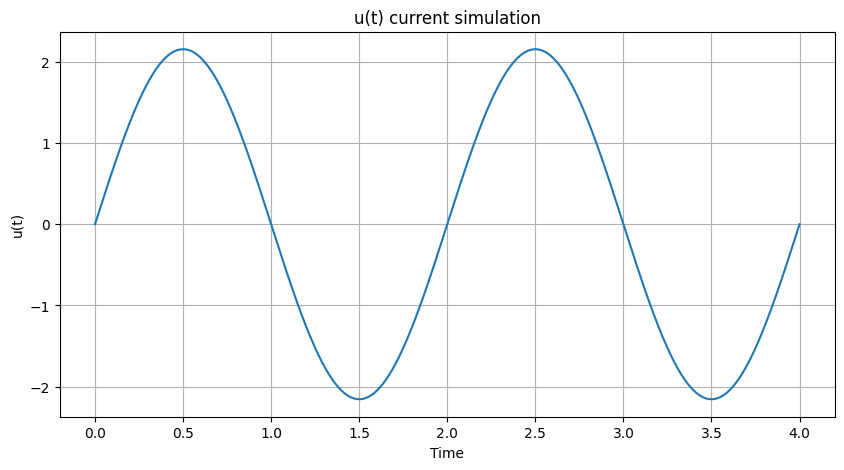

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:08,  8.62s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:17<01:02,  8.94s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:27<00:54,  9.08s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:38<00:50, 10.10s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:46<00:37,  9.45s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:55<00:27,  9.03s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:04<00:17,  8.97s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:13<00:09,  9.19s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:22<00:00,  9.20s/it]


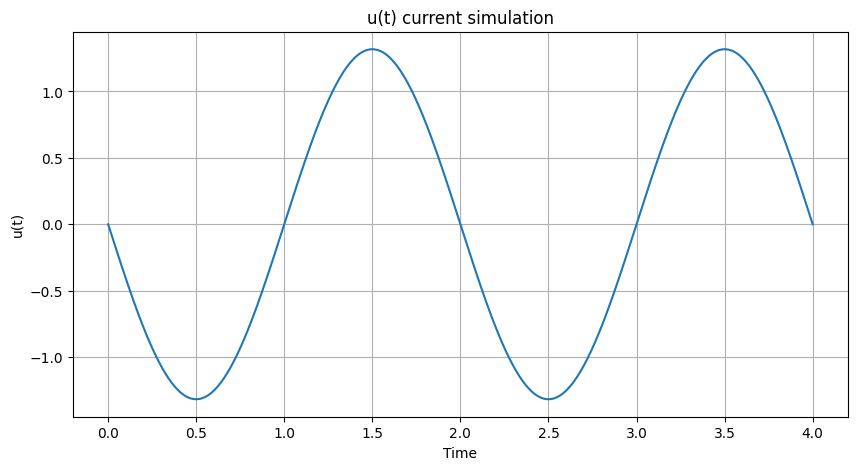

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:10<01:22, 10.28s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:19<01:07,  9.58s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:27<00:53,  8.95s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:35<00:42,  8.56s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:43<00:33,  8.29s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:51<00:24,  8.20s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [00:59<00:16,  8.07s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:07<00:08,  8.03s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:14<00:00,  8.33s/it]


In [10]:
if __name__ == "__main__":
    main()